# import utils

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import copy
from math import radians, sin, cos, sqrt, atan2

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from lightgbm import LGBMRegressor

import eli5
from eli5.sklearn import PermutationImportance

# load datasets

In [2]:
train_path = '/data/ephemeral/home/data/train.csv'
test_path = '/data/ephemeral/home/data/test.csv'
train_df  = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df['is_test'] = 0
test_df['is_test'] = 1
concat_df = pd.concat([train_df, test_df])

print(train_df.shape) #(1118822, 53)
print(test_df.shape)  #(9272, 52)
print(concat_df.shape) #(1128094, 53)

(1118822, 53)
(9272, 52)
(1128094, 53)


In [3]:
train_df_ = copy.deepcopy(train_df)
test_df_ = copy.deepcopy(test_df)
concat_df_ = copy.deepcopy(concat_df)

# EDA

## target (y) distribution

highest target value : 1450000
highest target value : 5400


Text(0.5, 1.0, 'Plot of distribution : 계약년월 vs. target')

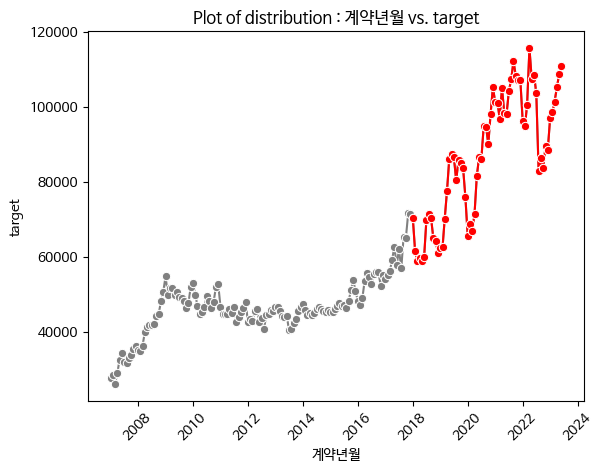

In [4]:
train_df_['계약년월']
train_df_['계약년월'] = pd.to_datetime(train_df_['계약년월'], format='%Y%m') #datetime으로 변환

# 계약년도에 따른 target 변화 그래프
sns.lineplot(x = '계약년월', y = 'target', data = train_df_,
             marker = 'o', color = 'gray', ci = None)  # 점점 상승하는 폭을 나타내지만, 2022년부터 2024년까지 갑자기줄어드는 현상
train_df_outlier = train_df_[(train_df_['계약년월'] >= '2018-01-01') & (train_df_['계약년월'] <= '2024-12-31')]
print("highest target value : {}".format(train_df_outlier.max()['target']))
highest_target = train_df_outlier.max()['target']
lowest_target = train_df_outlier.min()['target']

print("highest target value : {}".format(train_df_outlier.min()['target']))
#plt.axhline(y = highest_target, color = 'red', linestyle = '--')
#plt.axhline(y = lowest_target, color = 'red', linestyle = '--')

##2022 ~2024 까지 
sns.lineplot(x = '계약년월', y = 'target', data = train_df_outlier,
             marker = 'o', color = 'red', ci =None)
plt.xticks(rotation = 45)
plt.title('Plot of distribution : 계약년월 vs. target')

## Check nan ratio

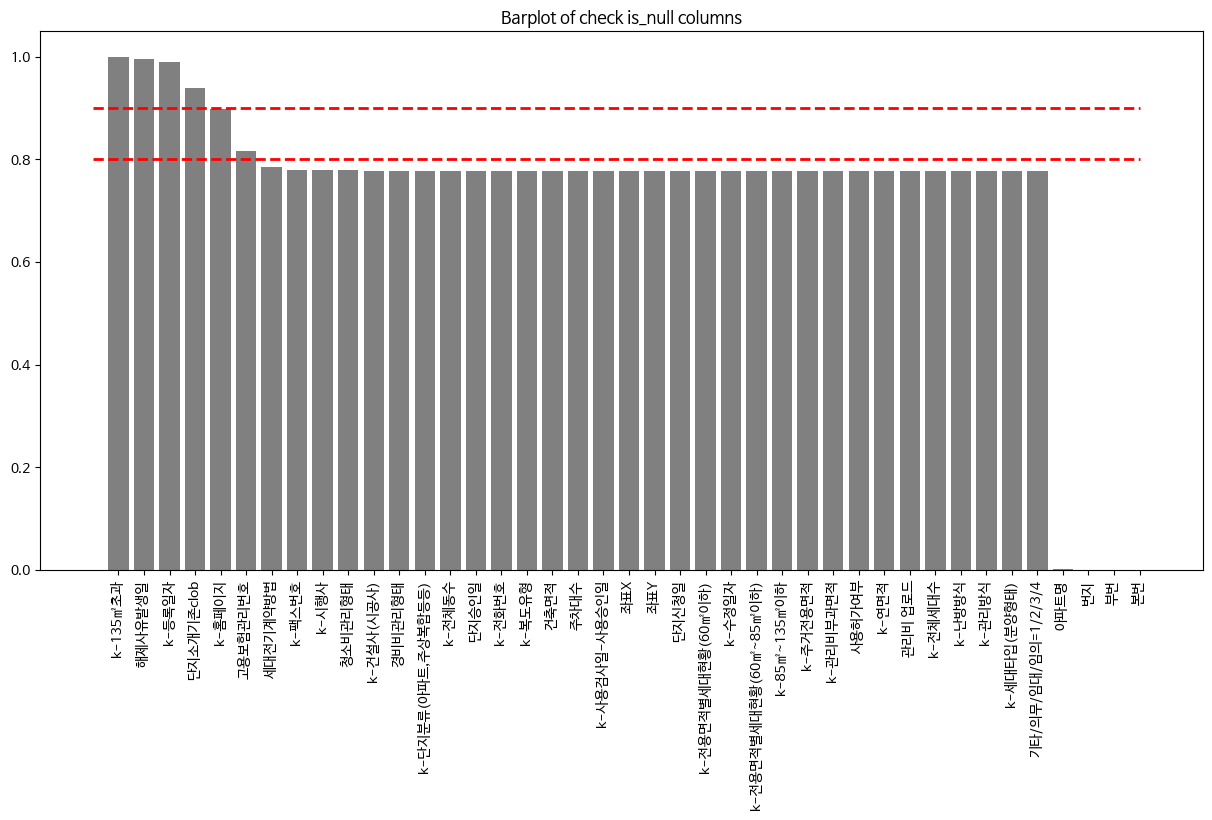

In [8]:
missing_num = concat_df.isnull().sum().sort_values(ascending = False)
missing_percentage = missing_num/concat_df.shape[0]
missing_info = pd.concat([missing_num,missing_percentage],axis=1,keys=['missing_number','missing_percentage'])
missing_info_notarget = missing_info[missing_info.index != 'target']
missing_info_ = missing_info_notarget[missing_info_notarget['missing_number']!= 0]

plt.figure(figsize=(15,7))
plt.bar(missing_info_.index, missing_info_.missing_percentage, color = 'gray')
plt.hlines(y = 0.8, xmin = -1, xmax = 40, color = 'red', linestyles= 'dashed', linewidth = 2) #결측값이 80% 이상
plt.hlines(y = 0.9, xmin = -1, xmax = 40, color = 'red', linestyles= 'dashed', linewidth = 2) # 결츠값이 90%이상
plt.xticks(rotation = 90, fontsize = 10)
plt.title("Barplot of check is_null columns")
plt.show()


In [9]:
# 결측값이 80% 이상인 변수는 모두 제외 (단, 좌표x, 좌표y 제외)
rm_col_lst = list(missing_info_[(missing_info_.index != '좌표X') & (missing_info_.index != '좌표Y') & (missing_info_.index != '아파트명') & (missing_info_.index != '번지') & (missing_info_.index != '부번') & (missing_info_.index != '본번')].index)

In [10]:
new_col_list = []
for i in list(concat_df.columns):
    if i not in rm_col_lst:
        new_col_list.append(i)
print(new_col_list)

['시군구', '번지', '본번', '부번', '아파트명', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '도로명', '등기신청일자', '거래유형', '중개사소재지', '좌표X', '좌표Y', 'target', 'is_test']


In [11]:
# 결측값이 80%이상인 변수를 제외한 새로운 df

concat_df_v1 = concat_df[new_col_list]  #(1128094, 18)

## 좌표X, 좌표Y

In [ ]:
#restapi 활용하기
import json
import requests

api_key = '3565d8117dbf5e77aebe3710ba824c91'

def addr_to_lat_lon(addr):
    url = f'https://dapi.kakao.com/v2/local/search/address.json?query={addr}'
    headers = {"Authorization": f"KakaoAK {api_key}"}
    response = requests.get(url, headers=headers)
    
    # 상태 코드 확인
    if response.status_code != 200:
        return None, None, response.status_code
    
    result = response.json()
    # 결과값이 없는 경우 처리
    if not result['documents']:
        return None, None, response.status_code
    
    match_first = result['documents'][0]['address']
    return float(match_first['x']), float(match_first['y']), response.status_code

# 주소 리스트를 처리하는 함수
def process_addresses(address_list):
    success_data = []  # 성공적으로 처리된 데이터 저장
    failed_addresses = []  # 실패한 주소 저장
    
    for addr in address_list:
        x, y, status = addr_to_lat_lon(addr)
        if status == 200 and x is not None and y is not None:
            success_data.append({"road_address": addr, "latitude": y, "longitude": x})
        else:
            failed_addresses.append({"address": addr, "status_code": status})
    
    # 성공 데이터프레임 생성
    success_df = pd.DataFrame(success_data)
    # 실패한 주소 리스트
    failed_df = pd.DataFrame(failed_addresses)
    
    return success_df, failed_df
'''
# 예제 주소 리스트
address_list = [
    "서울특별시 강남구 삼성동",
    "경기도 성남시 분당구 정자동",
    "유효하지 않은 주소"
]

# 처리 실행
success_df, failed_df = process_addresses(address_list)

# 결과 확인
print("Success DataFrame:")
print(success_df)
print("\nFailed Addresses DataFrame:")
print(failed_df)
'''

In [ ]:
#merge를 위한 고유값 생성
concat_df_v1['add_to_xy'] =  concat_df_v1[['시군구', '번지']].apply(lambda x:' '.join(map(str,x)), axis = 1) 

In [ ]:
# 좌표값 반환 / 실패 저장
address_list = list(concat_df_v1['add_to_xy'].unique())

success_df, failed_df = process_addresses(address_list) # 좌표x,좌표y가져오기
# 결과 확인
print("Success DataFrame:")
print(success_df)
print("Failed Addresses DataFrame:")
print(failed_df)

success_df.to_csv('/data/ephemeral/home/data/success_xy.csv')
failed_df.to_csv('/data/ephemeral/home/data/failed_xy.csv')


In [ ]:
# 실패했던 지번주소 ->(직접 검색)-> 도로명 주소변환-> 좌표x, 좌표y 구하기
add_xy_df = pd.read_csv('/data/ephemeral/home/data/failed_addxy_df.csv')

address_list_road = list(add_xy_df[~add_xy_df['road_address'].isna()]['road_address'])

success_df_add, failed_df_add = process_addresses(address_list_road) # 좌표x,좌표y가져오기
# 결과 확인
print("Success DataFrame:")
print(success_df_add)
print("Failed Addresses DataFrame:")
print(failed_df_add) #도로명주소로 변환했어도 실패 + 도로명 주소 못찾음

In [ ]:
#도로명으로도 변환 못한 주소 제외
add_xy_df_v1 = add_xy_df[~add_xy_df['road_address'].isna()] #116개는 도로명 찾음

len(add_xy_df_v1['road_address'].unique()) #112개가 unique 
#겹치는 것 : 서울특별시 강남구 삼성로 51길 37 / 서울특별시 서초구 서초중앙로 242 / 서울특별시 송파구 오금로 557

In [ ]:
add_xy_df_v2 = pd.merge(add_xy_df_v1,success_df_add, on = 'road_address')

In [ ]:
add_xy_df_v2 = add_xy_df_v2.drop(['Unnamed: 0','status_code', 'road_address'], axis = 1) #(97,3)

In [ ]:
add_xy_df_v3 = add_xy_df_v2.rename(columns = {'address' : 'add_to_xy','latitude' : '좌표Y','longitude' : '좌표X'})

In [ ]:
success_df = success_df.drop(['Unnamed: 0'],axis = 1)
success_df = success_df.rename(columns = {'address' : 'add_to_xy','latitude' : '좌표Y','longitude' : '좌표X'})

sucess_df_v4 = pd.concat([success_df,add_xy_df_v3])
concat_df_v1 = concat_df_v1.reset_index(drop = True)
sucess_df_v4 = sucess_df_v4.reset_index(drop = True)
sucess_df_v5 = sucess_df_v4.drop_duplicates()
print(sucess_df_v5.shape) #(8868,3)

# 파생변수 만들기

1. 역세권 고려하여 subway_feature.csv 파일 활용

In [ ]:
# Haversine formula to calculate distance between two points (in km)
def haversine(y1, x1, y2, x2):
    R = 6371  # Earth radius in kilometers
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [y1, x1, y2, x2])
    
    # Differences
    dlat = y2 - y1
    dlon = x2 - x1
    
    # Haversine formula
    a = sin(dlat / 2)**2 + cos(y1) * cos(y2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
#bus, subway feature 만들기
#bus_df = pd.read_csv('/data/ephemeral/home/data/bus_feature.csv')
sub_df = pd.read_csv('/data/ephemeral/home/data/subway_feature.csv') #역세권

#bus_df = bus_df.rename(columns = {'Y좌표' : '좌표Y','X좌표' : '좌표X'})
sub_df = sub_df.rename(columns = {'위도' : '좌표Y','경도' : '좌표X'})

In [ ]:
# 지하철역과의 최단거리변수
sub_results = []
for _, place in sucess_df_v5.iterrows():
    place_y, place_x = place["좌표Y"], place["좌표X"]
    min_distance = float("inf")
    closest_stop = None
    
    for _, stop in sub_df.iterrows():
        stop_y, stop_x = stop["좌표Y"], stop["좌표X"]
        distance = haversine(place_y, place_x, stop_y, stop_x)
        
        if distance < min_distance:
            min_distance = distance
            closest_stop = stop["역사_ID"]
    
    sub_results.append({
        "Place": place["add_to_xy"],
        "Closest_역사 ID": closest_stop,
        "sub_km": min_distance
    })
sub_results_df = pd.DataFrame(sub_results)

In [ ]:
sub_results_df = sub_results_df.rename(columns = {'Place' : 'add_to_xy','sub_km' : 'sub_shortest(km)'})

In [ ]:
#(좌표x,y)와 subway 합치기
success_df_v6 = pd.merge(sucess_df_v5, sub_results_df, on = 'add_to_xy')

In [ ]:
concat_df_v2 = pd.merge(concat_df_v1,success_df_v6, on = 'add_to_xy', how = 'left') #(1128094, 23)

In [ ]:
concat_df_v3 = concat_df_v2.drop(['좌표X_x', '좌표Y_x'],axis = 1)
concat_df_v3 = concat_df_v3.rename(columns = {'좌표Y_y' : '좌표Y','좌표X_y' : '좌표X'}) #좌표(x,y)결측값 876232 -> 12093

In [ ]:
concat_df_v3_ = copy.deepcopy(concat_df_v3)

In [ ]:
concat_df_v3_ = concat_df_v3_.drop(['번지', '본번', '부번','아파트명'], axis = 1)

In [ ]:
columns_to_exclude = ['target']
concat_df_v4_ = concat_df_v3_.dropna(subset=[col for col in concat_df_v3_.columns if col not in columns_to_exclude])

print(concat_df_v4_.shape) # (1116001,17)

concat_df_v4_copy = copy.deepcopy(concat_df_v4_)

## 전용면적 변수

In [ ]:
concat_df_v4_copy = concat_df_v4_copy.rename(columns={'전용면적(㎡)':'전용면적'})

In [ ]:
train_tmp = concat_df_v4_copy[concat_df_v4_copy['is_test'] == 0]

In [ ]:
'''
@@ 1. 전용면적
''' 
sns.scatterplot(x='전용면적', y='target', data = train_tmp,color = 'gray') #iqr기준으로하면 너무 많이 삭제되어서 upper bound를 가장 큰 값의 전용면적으로 대체


#sns.jointplot(x='전용면적', y='target', data=train_mdl, color='gray')
upper_imp  = train_tmp[train_tmp['target'] == train_tmp.max()['target']]['전용면적'].values

# 전용면적이 273.96인 지점에 빨간색 선 / IQR 방식은 파란색 선
plt.axvline(x = upper_imp, color='red', linestyle='--')
plt.axvline(x=21.68500000000001, color='blue', linestyle='--')
plt.axvline(x=122.92499999999998, color='blue', linestyle='--')
plt.title('Plot of distribution : 전용면적 vs. target')
plt.show()

In [ ]:
train_tmp_ = train_tmp.reset_index(drop = True)

upper_bound = train_tmp_[train_tmp_['target'] == train_tmp_.max()['target']]['전용면적'].values #273.96
for i in range(0,train_tmp_.shape[0]):
    if train_tmp_.loc[i,'전용면적'] > upper_bound:
        train_tmp_.loc[i,'전용면적'] == upper_bound
print(train_tmp_.shape)

In [ ]:
concat_df_v5_copy = pd.concat([train_tmp,concat_df_v4_copy[concat_df_v4_copy['is_test'] == 1]])

In [ ]:
'''
@@ 2. 전용면적 -> 전용면적to평수 -> 평수to그룹
''' 
def m2_to_pyeonsoo(df):
    df['전용면적to평수'] = df['전용면적'] / 3.3058
    df['전용면적to평수'] = df['전용면적to평수'].astype(int)
    return df

concat_df_v6_copy = m2_to_pyeonsoo(concat_df_v5_copy)

In [ ]:
#sns.scatterplot(x = 'sub_shortest(km)', y = 'target', data = concat_df_v6_copy)
#sns.scatterplot(x = '전용면적to평수', y = 'target', data = concat_df_v6_copy)
sns.scatterplot(x = '층', y = 'target', data = concat_df_v6_copy)

In [ ]:
concat_df_v7_copy = concat_df_v6_copy.drop(['등기신청일자', '거래유형', '중개사소재지'],axis = 1)

In [ ]:
#역세권 
#plt.boxplot(concat_df_v7_copy['sub_shortest(km)'])
sns.scatterplot(x = 'sub_shortest(km)', y = 'target', data = concat_df_v7_copy)
concat_df_v7_copy['near_sub'] = concat_df_v7_copy['sub_shortest(km)'].apply(lambda x: 1 if x > 50 else 0)

# LabelEncoder

In [ ]:
concat_df_v8_copy = concat_df_v7_copy.drop(['도로명', 'Closest_역사 ID', 'add_to_xy'],axis = 1)

In [ ]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_df_v8_copy.query('is_test==0')
dt_test = concat_df_v8_copy.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

In [ ]:
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns_[1:]):
    print(col)
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit(dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

# Model Traning

In [ ]:
dt_train_ = dt_train[dt_train['계약년월'] >= 201801]
dt_train_ = dt_train_.drop(['시군구'], axis = 1)
dt_train_ = dt_train_.reset_index(drop = True)

In [ ]:
y_train = dt_train_['target']
X_train = dt_train_.drop(['target'],axis = 1)

## lightgbm regressor

In [ ]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

num_leaves_list = [7,100,300]  # 트리의 리프 노드 수
max_depth_list = [7,10] # 트리의 최대 깊이
lr_list = [0.1]     # 학습률
n_estimators_list = [1000,2000] #부스팅 라운드 수
min_data_in_leaf_list = [10]
feature_fraction_list = [0.8,1.0]

all_ = [num_leaves_list, max_depth_list, lr_list, n_estimators_list, 
        min_data_in_leaf_list, feature_fraction_list]
hy_space = [s for s in itertools.product(*all_)]

results_lgbm = []
for hy in tqdm(hy_space):
    print(hy)
    mdllgbm = LGBMRegressor(num_leaves = hy[0], 
                             max_depth = hy[1],
                             learning_rate = hy[2],
                             n_estimators = hy[3],
                             min_sample_in_leaf =hy[4],
                             feature_fraction = hy[5] ,
                             boosting_type = 'dart',
                             objective='regression', random_state=777, n_jobs=-1)
                   
    fold_lgbm_rmse = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"Fold {fold + 1}")
        X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[val_idx]
        # 모델 학습
        mdllgbm.fit(X_train_, y_train_,
                    eval_set=[(X_val_, y_val_)],
                    eval_metric='rmse')

        # 예측
        y_pred_lgbm = mdllgbm.predict(X_val_)
        rmse_lgbm = np.sqrt(metrics.mean_squared_error(y_val_, y_pred_lgbm))
        fold_lgbm_rmse.append(rmse_lgbm)

    # 각 하이퍼파라미터 조합에 대한 평균 RMSE 계산
    avg_lgbm_rmse = np.mean(fold_lgbm_rmse)
    print("avg_lgbm_rmse : {}".format(avg_lgbm_rmse))
    # 결과 저장
    results_lgbm.append({'num_leaves' : hy[0], 
                         'max_depth' : hy[1],
                         'learning_rate' : hy[2],
                         'n_estimators' : hy[3],
                         'min_samples_in_leaf' : hy[4],
                         'feature_fraction' : hy[5] ,
                         'rmse' : avg_lgbm_rmse})

# 4. 결과를 DataFrame으로 변환
results_lgbm_df = pd.DataFrame(results_lgbm)
#print(results_df)

# 5. 최적의 하이퍼파라미터 및 결과 출력

best_result_lgbm = results_lgbm_df.loc[results_lgbm_df['rmse'].idxmin()]
print("최적의 하이퍼파라미터:")
print(best_result_lgbm)


In [ ]:
'''
### radomforest regressor 


n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# 모델 초기화
n_estimators_list = [50,100]  # 트리의 개수
max_depth_list = [7,10,20]     # 트리의 최대 깊이
min_samples_split_list = [1000]  # 최소 샘플 분할 수
min_samples_leaf_list = [3,5]    # 최소 잎 노드 샘플 수

all_ = [n_estimators_list, max_depth_list, min_samples_split_list, min_samples_leaf_list]
hy_space = [s for s in itertools.product(*all_)]

results = []
for hy in tqdm(hy_space):
    print(hy)

    # 3. 하이퍼파라미터 탐색
    mdlrf = RandomForestRegressor(n_estimators = hy[0], 
                                  max_depth = hy[1],
                                  min_samples_split= hy[2],
                                  min_samples_leaf= hy[3],
                                  max_features='auto',
                                  criterion='squared_error', random_state=777, n_jobs=-1)
    fold_rmse = []
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
        print(f"Fold {fold + 1}")
        X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # 모델 학습
        mdlrf.fit(X_train_, y_train_)

        # 예측
        y_pred = mdlrf.predict(X_val_)
        rmse = np.sqrt(metrics.mean_squared_error(y_val_, y_pred))
        fold_rmse.append(rmse)

    # 각 하이퍼파라미터 조합에 대한 평균 RMSE 계산
    avg_rmse = np.mean(fold_rmse)
    print(avg_rmse)

    # 결과 저장
    results.append({'n_estimators': hy[0], 
                    'max_depth' : hy[1],
                    'min_samples_split' : hy[2],
                    'min_samples_leaf' : hy[3],
                    'rmse': avg_rmse})

# 결과를 DataFrame으로 변환
results_df = pd.DataFrame(results)
print(results_df)

# 최적의 하이퍼파라미터 및 결과 출력
best_result = results_df.loc[results_df['rmse'].idxmin()]
print("최적의 하이퍼파라미터:")
print(best_result)
'''

# Model Validation

In [ ]:
lgbm_mdl = LGBMRegressor(num_leaves = 100, max_depth = 10, learning_rate=0.1, n_estimators=2000, 
                         min_samles_leaf = 10, feature_fraction = 1.0,
                         boosting_type = 'dart',objective='regression', random_state=777, n_jobs=-1)

fold_rmse = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 모델 학습
    lgbm_mdl.fit(X_train_, y_train_)

    # 예측
    y_pred = lgbm_mdl.predict(X_val_)
    rmse = np.sqrt(metrics.mean_squared_error(y_val_, y_pred))
    fold_rmse.append(rmse)

    # 각 하이퍼파라미터 조합에 대한 평균 RMSE 계산
    avg_rmse = np.mean(fold_rmse)
    print(avg_rmse)

In [ ]:
# 모델 저장
with open('/data/ephemeral/home/data/saved_mdl/20250112_lgbm_saved_model.pkl', 'wb') as f:
    pickle.dump(lgbm_mdl, f)

## load model and plotting "True vs. Pred"

In [ ]:
with open('/data/ephemeral/home/data/saved_mdl/20250112_lgbm_saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    print(f"Fold {fold + 1}")
    X_train_, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_, y_val_ = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 모델 학습
    #lgbm_mdl.fit(X_train_, y_train_)

    # 예측
    y_pred = lgbm_mdl.predict(X_val_)
    rmse = np.sqrt(metrics.mean_squared_error(y_val_, y_pred))
    
    plt.figure(figsize=(5,5))
    x = np.arange(y_val_.min(),y_val_.max())
    y = x
    plt.plot(x,y, color = 'black', linestyle = 'dashed', label = 'y=x')
    plt.scatter(y_val_, y_pred)
    plt.xlabel("True")
    plt.ylabel("Pred")
    plt.title("Scatter Plot of True vs. Pred for {} fold : {}(rmse)". format(fold+1,np.round(rmse,2)), fontsize = 10)
    plt.legend()
    plt.xticks(fontsize = 6, rotation = 90)
    plt.show()


In [ ]:
X_test = dt_test[X_train.columns]
# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

output = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
#output.to_csv("/data/ephemeral/home/data/submission/20250106/output_20250112.csv")

## Feature Importance

In [ ]:
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(8,5))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()